In [19]:
import heapq
import random as rd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
# code addapeted from session 5

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [4]:
class Queue:
    def __init__(self):
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0

    def add_customer(self):
        # Add the customer to the queue
        self.people_in_queue += 1
    
    def embark(self, n):
        self.people_in_queue -= n

class Bus:
    def __init__(self, initial_stop, 
                nStops=15, 
                time_moving_dist=sts.norm(loc=2,scale=0.5), 
                load_time_dist=sts.norm(loc = 0.03, scale = 0.01), 
                unload_time_dist=sts.norm(loc=0.05, scale = 0.01), 
                max_pass=130):

        self.nPassengers = 0
        self.cStop = initial_stop
        self.time_moving_dist = time_moving_dist
        self.max_pass = max_pass
        self.load_time_dist = load_time_dist
        self.unload_time_dist = unload_time_dist
        self.nStops = nStops
        self.stops = {i:0 for i in range(nStops)}

    def Load(self, *args):
        schedule = args[0]
        busSystem, stop= args[1]
        n = busSystem.queues[stop].people_in_queue
        if n + self.nPassengers > self.max_pass:
            n = self.max_pass - self.nPassengers
        self.nPassengers += n
        for _ in range(n):
            trip = stop + round(rd.random()*7)
            if trip > self.nStops-1:
                trip -= self.nStops
            self.stops[stop] += 1
        busSystem.queues[stop].embark(n)
        schedule.add_event_after(
            self.time_moving_dist.rvs()+self.load_time_dist.rvs()*n,
            self.Unload, (busSystem, self.cStop+1))
    
    def Unload(self, *args):
        schedule = args[0]
        busSystem, stop= args[1]
        if stop > self.nStops-1:
            stop -= self.nStops
        self.cStop = stop
        n = self.stops[stop]
        self.nPassengers -= n
        self.stops[stop] -= n
        schedule.add_event_after(
            self.unload_time_dist.rvs()*n,
            self.Load, (busSystem, self.cStop))

class BusSystem:
    def __init__(self, n_busses, 
                arrival_distribution=sts.expon(scale=1),
                bus_interval_dist = sts.norm(loc=4, scale=0.5), 
                n_stops=15):

        self.queues = {i:Queue() for i in range(n_stops)}
        self.arrival_distribution = arrival_distribution
        self.n_stops = n_stops
        self.busses = {i:Bus(0) for i in range(n_busses)}
        self.bus_interval_dist = bus_interval_dist

    def add_customer(self, *args):
        queue, schedule = args[1]
        # Add this customer to the queue
        self.queues[queue].add_customer()
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer, (queue, schedule))

    def run(self, schedule):
        # Schedule when the first customer arrives
        for i in range(self.n_stops):
            schedule.add_event_after(
                self.arrival_distribution.rvs(),
                self.add_customer, (i, schedule))

        for i,bus in self.busses.items():
            schedule.add_event_after(
                self.bus_interval_dist.rvs()*(i+1),
                bus.Load, (self,0))
        

def run_simulation(n_busses, run_until):
    schedule = Schedule()
    bus_system = BusSystem(n_busses)
    bus_system.run(schedule)
    people_waiting = []
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
        people_waiting.append(sum([bus_system.queues[i].people_in_queue for i in range(len(bus_system.queues))]))
    return people_waiting

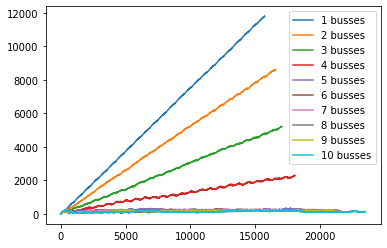

In [9]:
n = 10
start_n = 1
sims=[run_simulation(i, 1000) for i in range(start_n,n+1)]

for i,sim in enumerate(sims):
    plt.plot(range(len(sim)), sim, label=f'{i+start_n} busses')

plt.legend()
plt.show()

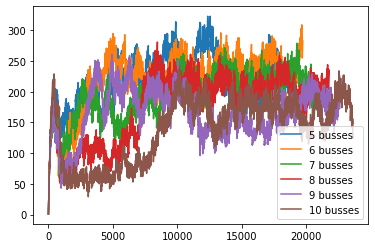

In [15]:
n = 10
start_n = 5
sims=[run_simulation(i, 1000) for i in range(start_n,n+1)]

for i,sim in enumerate(sims):
    plt.plot(range(len(sim)), sim, label=f'{i+start_n} busses')

plt.legend()
plt.show()

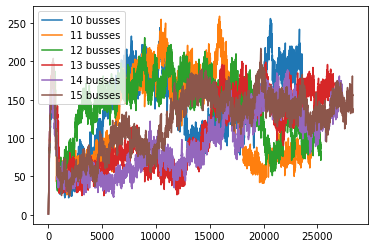

In [13]:
n = 15
start_n = 10
sims=[run_simulation(i, 1000) for i in range(start_n,n+1)]

for i,sim in enumerate(sims):
    plt.plot(range(len(sim)), sim, label=f'{i+start_n} busses')

plt.legend()
plt.show()

average total number of people wating:  249.3699217710606


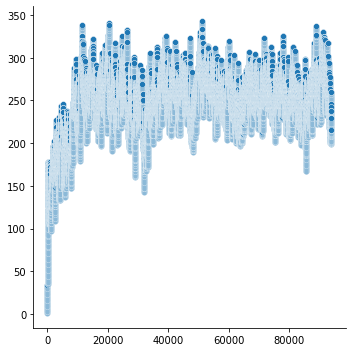

In [18]:
y=run_simulation(i, 5000)

print('average total number of people wating: ', np.mean(y))
sns.relplot(x=range(len(y)), y=y)
plt.show()

In [99]:
def run_simulation_data(n_busses, run_until):
    schedule = Schedule()
    bus_system = BusSystem(n_busses)
    bus_system.run(schedule)
    busses = [[] for _ in bus_system.busses]
    stops = [[] for _ in bus_system.queues]
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
        for i in range(len(bus_system.busses)):
            busses[i].append(bus_system.busses[i].nPassengers)
        for i in range(len(bus_system.queues)):
            stops[i].append(bus_system.queues[i].people_in_queue)
    
    df_bus = pd.DataFrame.from_dict({f'people_in_bus_{i}':busses[i] for i in range(len(busses))})
    df_stops = pd.DataFrame.from_dict({f'people_in_stop_{i}':stops[i] for i in range(len(stops))})
    
    return pd.concat([df_bus, df_stops], axis=1)


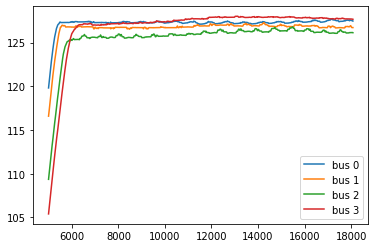

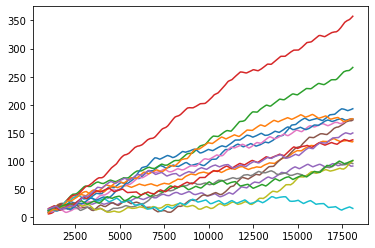

In [90]:
n_busses = 4

df = run_simulation_data(n_busses, 1000)

for i in range(n_busses):
    y=df[f'people_in_bus_{i}'].rolling(5000).mean()
    plt.plot(range(len(y)),y, label=f'bus {i}')

plt.legend()
plt.show()

for i in range(15):
    y=df[f'people_in_stop_{i}'].rolling(1000).mean()
    plt.plot(range(len(y)),y, label=f'stop {i}')
    

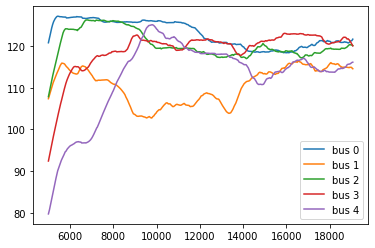

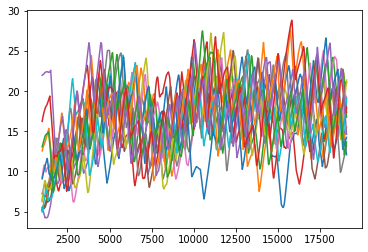

In [91]:
n_busses = 5

df = run_simulation_data(n_busses, 1000)

for i in range(n_busses):
    y=df[f'people_in_bus_{i}'].rolling(5000).mean()
    plt.plot(range(len(y)),y, label=f'bus {i}')

plt.legend()
plt.show()

for i in range(15):
    y=df[f'people_in_stop_{i}'].rolling(1000).mean()
    plt.plot(range(len(y)),y, label=f'stop {i}')

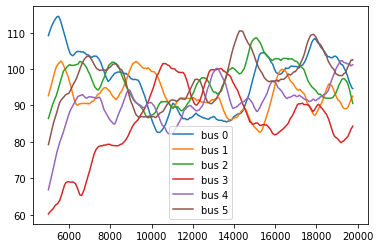

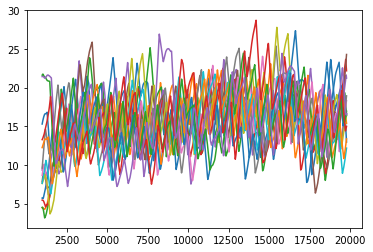

In [92]:
n_busses = 6

df = run_simulation_data(n_busses, 1000)

for i in range(n_busses):
    y=df[f'people_in_bus_{i}'].rolling(5000).mean()
    plt.plot(range(len(y)),y, label=f'bus {i}')

plt.legend()
plt.show()

for i in range(15):
    y=df[f'people_in_stop_{i}'].rolling(1000).mean()
    plt.plot(range(len(y)),y, label=f'stop {i}')

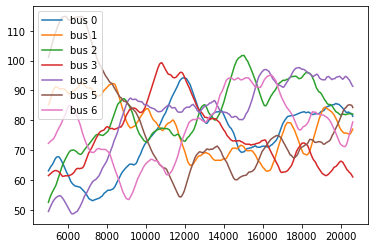

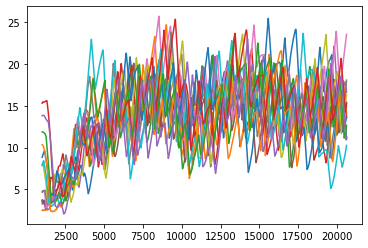

In [93]:
n_busses = 7

df = run_simulation_data(n_busses, 1000)

for i in range(n_busses):
    y=df[f'people_in_bus_{i}'].rolling(5000).mean()
    plt.plot(range(len(y)),y, label=f'bus {i}')

plt.legend()
plt.show()

for i in range(15):
    y=df[f'people_in_stop_{i}'].rolling(1000).mean()
    plt.plot(range(len(y)),y, label=f'stop {i}')

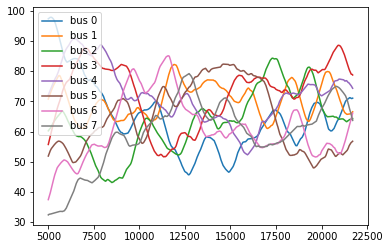

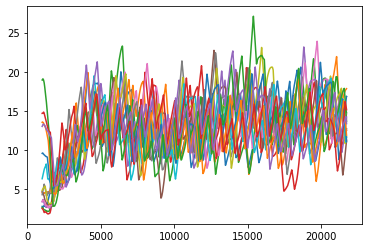

In [94]:
n_busses = 8

df = run_simulation_data(n_busses, 1000)

for i in range(n_busses):
    y=df[f'people_in_bus_{i}'].rolling(5000).mean()
    plt.plot(range(len(y)),y, label=f'bus {i}')

plt.legend()
plt.show()

for i in range(15):
    y=df[f'people_in_stop_{i}'].rolling(1000).mean()
    plt.plot(range(len(y)),y, label=f'stop {i}')

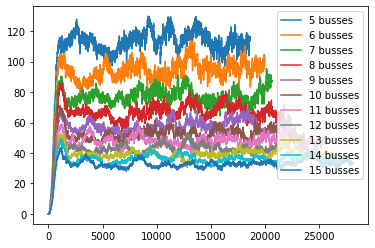

In [98]:
n = 15
start_n = 5
sims=[run_simulation_data(i, 1000).iloc[: , :i].mean(1) for i in range(start_n,n+1)]

for i,sim in enumerate(sims):
    plt.plot(range(len(sim)), sim, label=f'{i+start_n} busses')

plt.legend()
plt.show()